In [3]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist

import mlflow
import mlflow.tensorflow

Text(0.5, 1.0, '9')

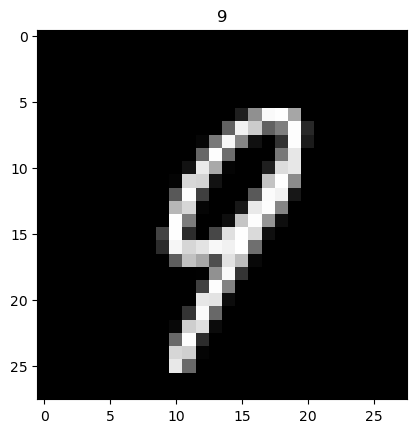

In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.imshow(X_train[22], cmap='gray')
plt.title(y_train[22])

In [17]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [18]:
# Reduzir dimensionalidade preservando 95% de sua variancia, para ocupar menos espaço. Cada instância terá pouco mais de 150 features, reduzindo 20% do tamanho
from sklearn.decomposition import PCA
pca = PCA(n_components = 154)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

In [19]:
X_train_reduced = X_train_reduced.astype('float32')
X_test_reduced = X_test_reduced.astype('float32')
#X_train_recovered = pca.inverse_transform(X_train_reduced)
X_train_reduced /= 255
X_test_reduced /= 255

In [20]:
#transformando target em dummy (onehotencoder)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [7]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
def train_nn(hidden_layers, neurons, activation_function_hidden, drop_out, epochs):
    mlflow.set_experiment('nnexperimento')

    with mlflow.start_run():
        mlflow.tensorflow.autolog()

        #registro de tags
        mlflow.set_tag('hidden_layers', hidden_layers)
        mlflow.set_tag('neurons', neurons)
        mlflow.set_tag('activation_function_hidden', activation_function_hidden)
        mlflow.set_tag('drop_out', drop_out)
        mlflow.set_tag('epochs', epochs)
        
        model = Sequential()
        #primeira camada oculta + camada de entrada
        model.add(Dense(units=neurons, activation=activation_function_hidden, input_dim=154))
        model.add(Dropout(drop_out))

        #camadas ocultas adicionais com dropout
        for n in range(hidden_layers):
            model.add(Dense(units=neurons, activation=activation_function_hidden))
            model.add(Dropout(drop_out))

        #camada de saída com 10 saídas
        model.add(Dense(units=10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        model.summary()

        histdata = model.fit(X_train_reduced, y_train, epochs=epochs, validation_data=(X_test_reduced, y_test))

        #graficos
        histdata.history.keys()
        loss = plt.plot(histdata.history['val_loss']) #diferenca entre predito e observado
        plt.savefig('loss.png')
        #plt.close()

        acc = plt.plot(histdata.history['val_accuracy']) #diferença entre erros e acertos
        plt.savefig('acc.png')

        #registrar artefatos
        mlflow.log_artifact('loss.png')
        mlflow.log_artifact('acc.png')        

        #info para execucao
        print('Modelo: ', mlflow.active_run().info.run_uuid)

        #mlflow.sklearn.log_model(model, 'modelnn')
    mlflow.end_run()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 16)                2480      
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_48 (Dense)            (None, 16)                272       
                                                                 
 dropout_34 (Dropout)        (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 10)              

1875/1875 [==============================] - 8s 3ms/step - loss: 1.1679 - accuracy: 0.5932 - val_loss: 4.6398 - val_accuracy: 0.1392
Epoch 2/2
  45/1875 [..............................] - ETA: 4s - loss: 0.8058 - accuracy: 0.7389

c:\Users\josen\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 71ms/step
INFO:tensorflow:Assets written to: C:\Users\josen\AppData\Local\Temp\tmp4ymk9gwx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\josen\AppData\Local\Temp\tmp4ymk9gwx\model\data\model\assets


Modelo:  bf50d26d064a428c877891f4b741d9e2


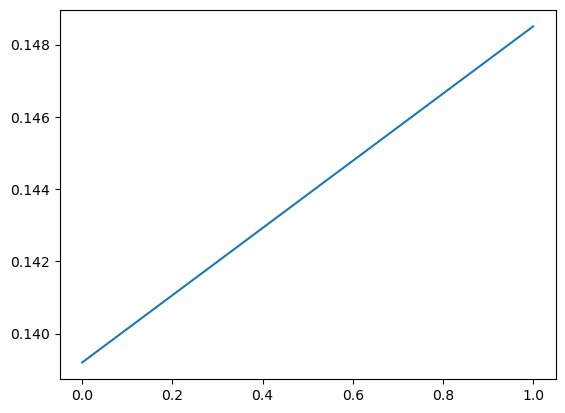

In [26]:
train_nn(2, 16,'relu',0.2,2)

In [27]:
"""
hidden_layers = [1, 2, 3]
neurons = [10,32,64]
activation = ['relu', 'tanh']
drop_out = [0.1, 0.2]
epochs = [5, 10, 20]

# 108 modelos

for layers in hidden_layers:
    for n in neurons:
        for act in activation:
            for drop in drop_out:
                for e in epochs:
                    train_nn(layers, n, act, drop, e)
"""

"\nhidden_layers = [1, 2, 3]\nneurons = [10,32,64]\nactivation = ['relu', 'tanh']\ndrop_out = [0.1, 0.2]\nepochs = [5, 10, 20]\n\n# 108 modelos\n\nfor layers in hidden_layers:\n    for n in neurons:\n        for act in activation:\n            for drop in drop_out:\n                for e in epochs:\n                    train_nn(layers, n, act, drop, e)\n"

#### Para servir o modelo
#### mlflow models serve --model-uri runs :/runid/log_name -p 2345